# Recommendations Systems
## Assignment 2: Content Based Recommendations 

**By:**  

Gil Zeevi<br>
Gil Ayache


**The goal of this assignment is to:**
- Understand the details of content based recommender systems
- Understand pros&cons comparing to other recommender system approaches
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).


**Grading:**
- Q1 - 10 points - Data exploration
- Q3 - 30 points - Item similarity
- Q4 - 40 points - Content based recommendation  
- Q5 - 20 points - Content based vs. matrix factorization comparison

`Total: 100`

**Prerequisites**

In [1]:
# !pip install --quiet zipfile36
# !pip install --quiet wordcloud

**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings
import urllib
import string

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["axes.labelsize"] = 15


# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [3]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [5]:
random.seed(123)

In [6]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

**Data Loading - the same as hw1:**

**Columns Names**

In [7]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [8]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [9]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file - SECOND FOLD**

In [10]:
df_ratings = pd.read_csv('{}u{}.base'.format(data_dir,2), delimiter='\t', header=None, names=cols_data)
df_ratings.shape

(80000, 4)

Making sure shapes are mathing the info data file

In [11]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

### Matrix:

In [12]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         0.0   0.0   4.0   3.0   3.0   5.0   4.0   0.0   0.0   3.0  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1648 columns]

**Choose fold**

In [13]:
ratings_full = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
ratings_full= ratings_full.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings_full.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 2 # AS INSTRUCTED -choosing fold number 2
train,test = getfulldf(*fold2df(fold))
train = train.fillna(0)
test= test.fillna(0)
train.shape,test.shape

((943, 1682), (943, 1682))

In [14]:
#my_metrics from HW1
class my_metrics():
        
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        if type(df_pred) == type(np.array([1])):
            if type(df_true) ==type(pd.DataFrame()):
                df_true = df_true.fillna(0)
                df_true = df_true.values
            df_pred[df_pred > upper_bound] = upper_bound
            df_pred[df_pred < lower_bound] = lower_bound
            flag =  df_true != 0
            s_e = ((df_true-df_pred) * flag)**2
            return np.sqrt(s_e.sum()/ flag.sum())
        flag =  df_true.values != 0 # a flag vector which if multiplies, gives score to non zero values
        s_e = ((df_true.values-df_pred.values) * flag)**2
        return np.sqrt(s_e.sum()/ flag.sum())
    
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,threshold=3,MF = False):
        # please use MRR_for_user
        if MF: # if the prediction arrived from matrix factorization method -> fix it with bounds
            df_pred[df_pred > upper_bound] = upper_bound
            df_pred[df_pred < lower_bound] = lower_bound
        zero_counter = 0
        counter = 0
        for r in df_pred.index:# sum the Reciprocal Ranks
            rr = my_metrics.MRR_for_user(df_true.loc[r],df_pred.loc[r],lower_bound,upper_bound,top_n,threshold)
            if not rr: zero_counter+=1
            counter+= rr
        if (len(df_true) - zero_counter) == 0:
            return 0
        return counter / (len(df_true) - zero_counter) #return the mean Reciprocal Ranks
        

    def MRR_for_user(user_true: pd.Series,user_pred: pd.Series,lower_bound=1,upper_bound=5,top_n=5,threshold=3):
        act = user_true[user_true >0]
        pr = user_pred.loc[act.index].reset_index(drop=True).nlargest(top_n)
        if not pr.size: #rating has faild to be predicted
            return 0
        if pr.nlargest(1).values[0] < threshold: #faild to predict high rating
            return 0
        pr = pr[pr > 0]
        act = act.reset_index(drop=True).loc[pr.index]
        if act.nlargest(1).values[0] < threshold:
            return 0
        return 1 / (pr.isin(pr.loc[act.nlargest(1).index]).reset_index(drop=True).nlargest(1).index[0] + 1)   
    
    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,MF = False):
        # please use NDCG_for_user
        if MF: # if the prediction arrived from matrix factorization method -> fix it with bounds
            df_pred[df_pred > upper_bound] = upper_bound
            df_pred[df_pred < lower_bound] = lower_bound
        zero_counter = 0   
        counter = 0
        for r in df_pred.index:# apply Discounted Cumulative Gain for each user and sum it
            dcg, ndcg = my_metrics.NDCG_for_user(df_true.loc[r],df_pred.loc[r],lower_bound,upper_bound,top_n)
            if (ndcg == 0): zero_counter+=1
            counter+= 0 if (ndcg == 0) else (dcg / ndcg)
        if (len(df_true) - zero_counter) == 0:
            return 0
        return counter / (len(df_true) - zero_counter) #return the mean NDCG
        
    def NDCG_for_user(user_true: pd.Series,user_pred: pd.Series,lower_bound=1,upper_bound=5,top_n=5):
        # please use DCG function
        user_true = user_true[user_true >0]
        user_pred = user_pred.loc[user_true.index]
        idx = user_pred.nlargest(top_n).index
        rel = user_true.loc[idx]
        rel_ideal = user_true.loc[idx].sort_values(ascending = False)
        dcg, ndcg = my_metrics.DCG(rel),my_metrics.DCG(rel_ideal)
        return dcg, ndcg
    
    def DCG(rel: pd.Series):
        # please implement the DCG formula
        rel.reset_index(drop = True,inplace = True) 
        return (rel/ np.log2(rel.index +2)).sum()
        
    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


### Creating movie's picture generator:

In [15]:
pics = pd.read_csv('https://raw.githubusercontent.com/ShopRunner/collie/main/data/movielens_posters.csv',delimiter=',').set_index('item_id')
pics.loc[72] = 'https://m.media-amazon.com/images/I/71-NkSYGuSL._SL1384_.jpg'
def plot_pics(items : list,size = (12,6)):
    fig, ax = plt.subplots(1, len(items), figsize = size)
    for i, item in enumerate(items):
        ax[i].axis('off')
        ax[i].imshow(plt.imread(urllib.request.urlopen(pics.url.loc[item]), 0))
    fig.tight_layout()

# Question 1: 
# Data exploration 

In this exercise you will use the same dataset that we used for exercise #1:  [MovieLens 100K rating dataset](https://grouplens.org/datasets/movielens/100k/)  use Fold #2

Include additional exploration that is relevant for content based recommendation.  
Explore at least 3 features, one of the features should be text (e.g. movie title). 

Use plots and discuss your insights and possible challenges related to the dataset.


In [16]:
user_rating_df = pd.merge(df_ratings,df_users,on='user_id')
user_rating_df.rename(columns={'item_id': 'movie id'}, inplace=True)
total_df = pd.merge(user_rating_df,df_items,on = 'movie id')
total_df.head()

user_id  movie id  rating  timestamp  age gender     occupation zip code  \
0        1         3       4  878542960   24      M     technician    85711   
1       49         3       3  888068877   23      F        student    76111   
2       62         3       3  879372325   27      F  administrator    97214   
3       63         3       2  875748068   31      M      marketing    75240   
4       81         3       4  876592546   21      M        student    21218   

         movie_title release_date  ...  Fantasy Film_Noir  Horror  Musical  \
0  Four Rooms (1995)  01-Jan-1995  ...        0         0       0        0   
1  Four Rooms (1995)  01-Jan-1995  ...        0         0       0        0   
2  Four Rooms (1995)  01-Jan-1995  ...        0         0       0        0   
3  Four Rooms (1995)  01-Jan-1995  ...        0         0       0        0   
4  Four Rooms (1995)  01-Jan-1995  ...        0         0       0        0   

   Mystery  Romance  Sci_Fi  Thriller  War  Western  
0        0        0       0         1    0        0  
1        0        0       0         1    0        0  
2        0        0       0         1    0        0  
3        0        0       0         1    0        0  
4        0        0       0         1    0        0  

[5 rows x 31 columns]

First feature exploration - Gender distribution:

In [17]:
# A helper function to print precentage on bar plots
def show_precent(plot, feature,a_or_b = True):
    total = len(feature)
    if a_or_b:
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size = 15,bbox=dict(boxstyle="round",
                          fc=(1.0, 0.7, 0.7),
                          ec=(1., .5, .5)))
        plt.show()
    else:
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() / 2 - 0.25
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size = 15)
        plt.xticks(fontsize= 12)
        plt.yticks(fontsize= 12)
        plt.xticks(rotation=45)
        plt.show()

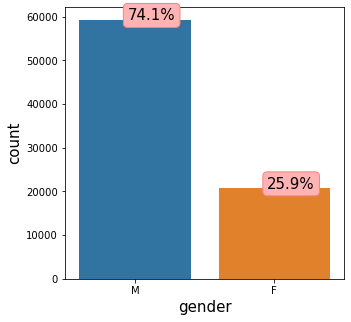

In [18]:
plt.rcParams["figure.figsize"] = (5,5)
g = sns.countplot('gender',data = total_df)
show_precent(g,  total_df.gender)

**The feature above might yield biases because the data doesn't represent the real proportion between men and women which is ~50-50.**

Second feature exploration - age distribution:

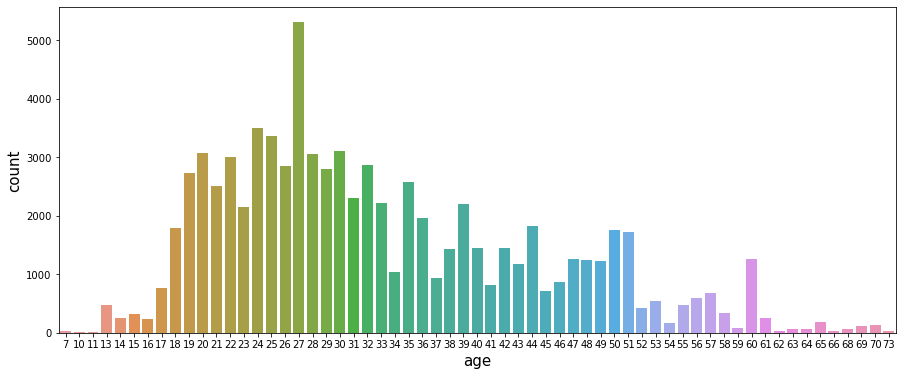

In [19]:
plt.figure(figsize=(15,6))
sns.countplot('age',data = total_df)
plt.show()

We can see that the Age of user distribute somewhat as a LogNormal distribution

### Yearly trend of ratings by ages


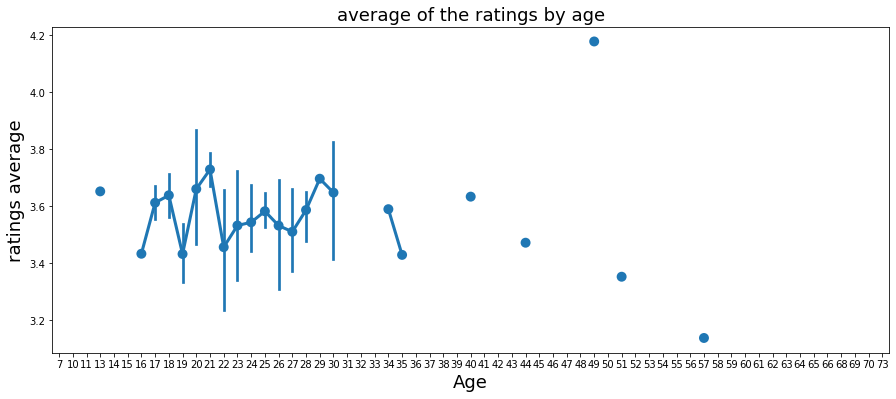

In [20]:
plt.figure(figsize=(15,6))
sns.pointplot(x=total_df['age'], y =total_df.groupby('age')['rating'].mean() ,scale=1.13)
plt.xlabel("Age",fontsize = 18)
plt.ylabel("ratings average",fontsize = 18)
plt.title("average of the ratings by age",fontsize = 18)
plt.show()

The average ratings for the users that are older than 40 years old has a sagnificant high variance - maybe due to accidentally rating?

third feature exploration - occupation distribution:

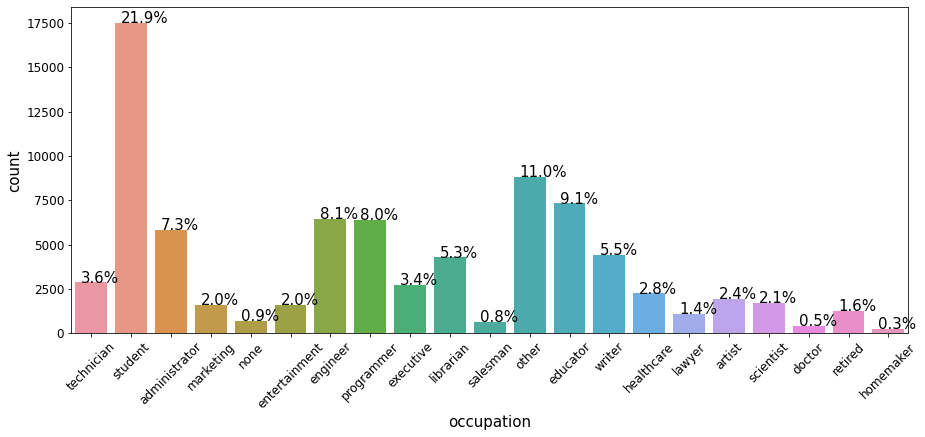

In [21]:
plt.figure(figsize=(15,6))
g = sns.countplot(x = 'occupation' ,data = total_df)
show_precent(g,  total_df.occupation,a_or_b = False)


Students have large impact in our data which might lead to imbalances!

**Text Exploration**

One of the popular tools for text data exploration is word cloud. Other options may include word distribution. 

Add a plots for your analysis and describe your insights. 

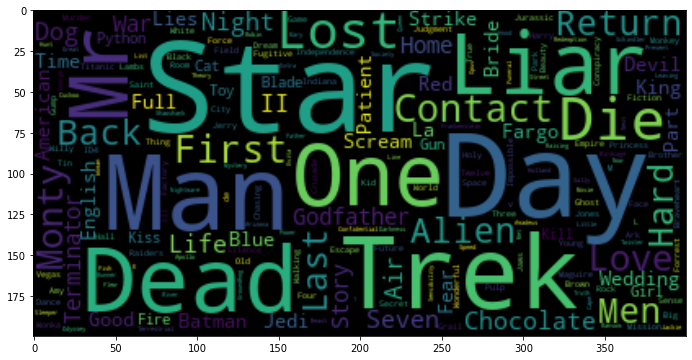

In [22]:
#Creating the text variable
plt.figure(figsize=(15,6))
text = " ".join(title for title in total_df.movie_title)

# Creating word_cloud with text as argument in .generate() method

word_cloud = WordCloud(collocations = False, background_color = 'black').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

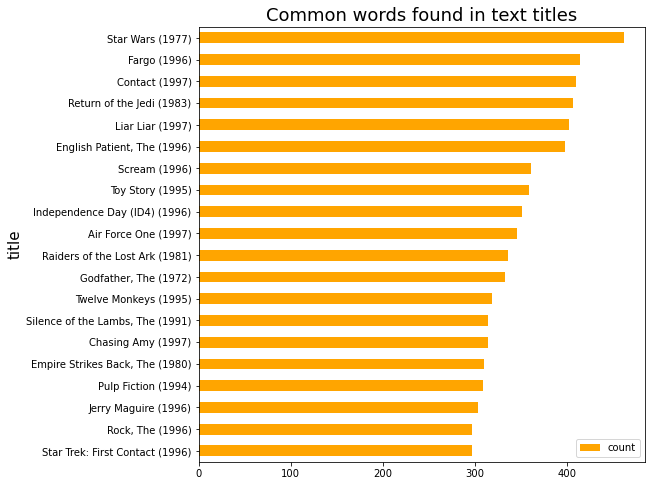

In [23]:
n = 20
top_n_titles = total_df.movie_title.value_counts().nlargest(n)
top_n_titles = pd.DataFrame(top_n_titles.reset_index().values, columns=["title", "count"])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
top_n_titles.sort_values(by='count').plot.barh(x='title',
                      y='count',
                      ax=ax,
                      color="orange")

ax.set_title("Common words found in text titles",fontsize= 18)

plt.show()

# Insights from the text analysis:<br>
The most frequent words in the titles are coming from the fact that there are several movies that appear many times in our dataset and get many voting:

- Star (Star Wars)

- Liar (Liar Liar) - a popular 

- Trek (Star Trek)

- Day (Independence Day)

<br><br><br><br><br><br>
# Question 2:
# Item Similarity

The following blog posts [link1](https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7), [link2](https://towardsdatascience.com/movie-recommendation-system-based-on-movielens-ef0df580cd0e), will be helpful for answering questions 2 and 3. 

Please answer, code, and explain your answer.  
In case you don't have a clear answer, please mention your hypothesis.

### Build a movie profile vector based on the item features of your choice. 
Select at least two features. Discuss the contribution of each feature
Tip: When looking on the MovieLens dataset it's features vector will include `genres`, `title`, etc.

We decided to build a profile which includes all the genres. this is making sense the most when thinking of expressing the user matrix with latent factors - the genres can express the latent meaning.

In [24]:
print("Show all features of movies:")
df_items.columns.tolist()

Show all features of movies:


['movie id',
 'movie_title',
 'release_date',
 'video_release_date',
 'IMDb_URL',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 'Childrens',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film_Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci_Fi',
 'Thriller',
 'War',
 'Western']

In [25]:
irelevent_cols = ['unknown','release_date','video_release_date','IMDb_URL','movie_title','movie id']
movies_profile = df_items.drop(irelevent_cols,axis=1)
movies_profile

Action  Adventure  Animation  Childrens  Comedy  Crime  Documentary  \
0          0          0          1          1       1      0            0   
1          1          1          0          0       0      0            0   
2          0          0          0          0       0      0            0   
3          1          0          0          0       1      0            0   
4          0          0          0          0       0      1            0   
...      ...        ...        ...        ...     ...    ...          ...   
1677       0          0          0          0       0      0            0   
1678       0          0          0          0       0      0            0   
1679       0          0          0          0       0      0            0   
1680       0          0          0          0       1      0            0   
1681       0          0          0          0       0      0            0   

      Drama  Fantasy  Film_Noir  Horror  Musical  Mystery  Romance  Sci_Fi  \
0         0        0          0       0        0        0        0       0   
1         0        0          0       0        0        0        0       0   
2         0        0          0       0        0        0        0       0   
3         1        0          0       0        0        0        0       0   
4         1        0          0       0        0        0        0       0   
...     ...      ...        ...     ...      ...      ...      ...     ...   
1677      1        0          0       0        0        0        0       0   
1678      0        0          0       0        0        0        1       0   
1679      1        0          0       0        0        0        1       0   
1680      0        0          0       0        0        0        0       0   
1681      1        0          0       0        0        0        0       0   

      Thriller  War  Western  
0            0    0        0  
1            1    0        0  
2            1    0        0  
3            0    0        0  
4            1    0        0  
...        ...  ...      ...  
1677         0    0        0  
1678         1    0        0  
1679         0    0        0  
1680         0    0        0  
1681         0    0        0  

[1682 rows x 18 columns]

### Build a function which provides the 5 most similar items to a specific item. 
Please use `Cosine Similarity` metric to calculate Item to item similarity.


In [26]:
def get_similar_items(movie_profiles,item_id,n=5): # you can add no_self=True for debbuging
    ''' 
    movie_profiles: movie profiles of all candidate movies
    item_id : target item 
    n : number of similar items to return
    
    This function returns a dataframe\array with ids of n most similar items to the target item and the similarity score
    '''
    corr_mat = cosine_similarity(movie_profiles)
    #making sure the selected item will be picked, because:
    # after examining the results, there can be more than one similarity scores with the score of 1
    corr_mat[item_id,item_id] = 999 
    if corr_mat[item_id].argsort()[::-1][0] != item_id:
        most_similar_items_id = np.concatenate((np.array(item_id),corr_mat[item_id].argsort()[::-1][:n]),axis=None)
    else:
        most_similar_items_id = corr_mat[item_id].argsort()[::-1][:n+1] #n+1 because the most correlated movie is with itself so we need another entry
    most_similar_item_score = corr_mat[item_id][most_similar_items_id]
    most_similar_item_score[0] = 1
    return most_similar_items_id,most_similar_item_score

We wanted to add some "wrapper" function to create a dataframe from the output of get_similar_items functiom:

In [27]:
def get_corr_df(movie_profiles,item_id,n=5):
    idx,res = get_similar_items(movie_profiles,item_id,n)
    irelevent_cols = ['unknown','release_date','video_release_date','IMDb_URL','movie id']
    df = df_items.iloc[idx].drop(irelevent_cols,axis=1)
    df.insert(1, 'Similarity', res)
    return df

### Use the above function to find the 5 most similar items for 2 items from the dataset. 
Please discuss the results you got. Are there any challenges? 

Please add the movie's title and image to your explanation.  (see example)

### Batman And Robin correlation (awful movie omg):

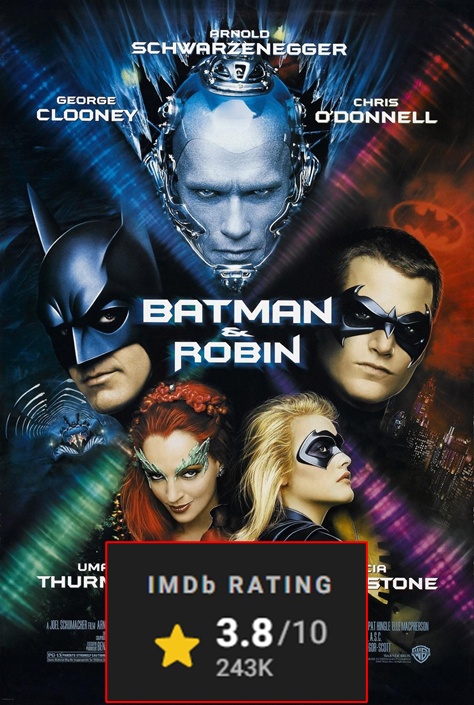

In [28]:
# first
bat_like = 253
batdf = get_corr_df(movies_profile,bat_like,n=5)
batdf

movie_title  Similarity  Action  Adventure  Animation  \
253       Batman & Robin (1997)    1.000000       1          1          0   
575          Cliffhanger (1993)    1.000000       1          1          0   
23   Rumble in the Bronx (1995)    1.000000       1          1          0   
28        Batman Forever (1995)    0.866025       1          1          0   
801          Hard Target (1993)    0.866025       1          1          0   
230       Batman Returns (1992)    0.866025       1          1          0   

     Childrens  Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  Horror  \
253          0       0      1            0      0        0          0       0   
575          0       0      1            0      0        0          0       0   
23           0       0      1            0      0        0          0       0   
28           0       1      1            0      0        0          0       0   
801          0       0      1            0      0        0          0       0   
230          0       1      1            0      0        0          0       0   

     Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  
253        0        0        0       0         0    0        0  
575        0        0        0       0         0    0        0  
23         0        0        0       0         0    0        0  
28         0        0        0       0         0    0        0  
801        0        0        0       0         1    0        0  
230        0        0        0       0         0    0        0

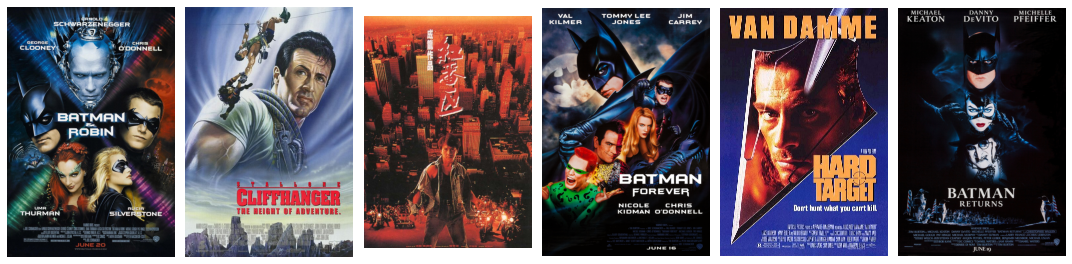

In [29]:
plot_pics(batdf.index+1,size = (15,10))

<u> **Insights:** </u>


In this pick, we can see that batman forever and batman returns were picked together with batman & robin as it should be on the one hand. on the other hand those movie got less similarity than cliffhanger and Rumble in the Bronx which actually doesnt make sense.<br>

in general, in genres perspective, the pickings were pretty good and chose movie of combats and somewhat vigilanties, mixed with some Sci-Fy.<br>
i Would expect to see also batman(1989) in the list ,which movies with same name and same type of genre, it only makes sense that they should be correlated the highest together.
<br><br>
Another problem is the generic grades which is given as Batman Forever and Hard Target got the same score exactly, which doesnt make sense

### The mask -  correlations:

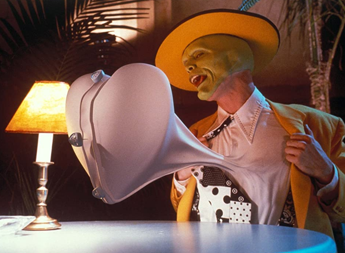

In [30]:
# second
mask_like = 71
mask_df=get_corr_df(movies_profile,71,n=5)
mask_df

movie_title  Similarity  Action  Adventure  Animation  \
71              Mask, The (1994)    1.000000       0          0          0   
119            Striptease (1996)    0.816497       0          0          0   
247   Grosse Pointe Blank (1997)    0.816497       0          0          0   
193            Sting, The (1973)    0.816497       0          0          0   
481      Some Like It Hot (1959)    0.816497       0          0          0   
1035       Drop Dead Fred (1991)    0.816497       0          0          0   

      Childrens  Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  \
71            0       1      1            0      0        1          0   
119           0       1      1            0      0        0          0   
247           0       1      1            0      0        0          0   
193           0       1      1            0      0        0          0   
481           0       1      1            0      0        0          0   
1035          0       1      0            0      0        1          0   

      Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  
71         0        0        0        0       0         0    0        0  
119        0        0        0        0       0         0    0        0  
247        0        0        0        0       0         0    0        0  
193        0        0        0        0       0         0    0        0  
481        0        0        0        0       0         0    0        0  
1035       0        0        0        0       0         0    0        0

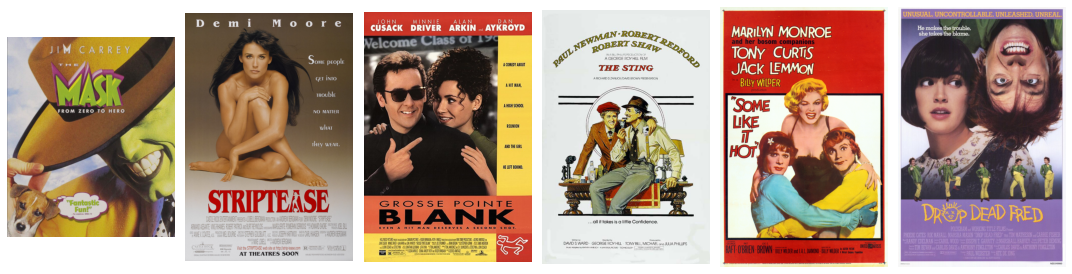

In [31]:
plot_pics(mask_df.index+1,size = (15,10))

<u> **Insights:** </u>


In this pick, The correlation didnt produce a good result in my opinion.<br> i dont think a "wacko" type of film such as the mask is similar in anyway to the others. yes they all are clustered in the same genres, but still they are far from each other by content - thus the correlation here doesnt really do a good job.<br><br>
i would expect to see more correlation with other Jim carrey nonesense films, which at the period he made plenty of those (Ace ventura, cable guy, dumb and dumber and so on).
<br><br>
furthermore, the air date of the movie must be taken into consideration, as when wanting to recommend a film , a 30 years difference between films is really significant, especially in the 60' - 70' where cinema was in a whole different scale, in terms of technology.

<br><br><br><br><br><br>
# Question 3:
# Content based recommendation



### Build a function which recommends 5 most relevant items to a user. 

In [32]:
def TFIDF(movies_profile):
    '''Calculating the TFIDF of the movies profile
       to reflect the importance of each genre in any movie
    '''
    IDF = np.log(len(movies_profile) / movies_profile.sum()) 
    TFIDF = movies_profile.mul(IDF,axis = 1)
    return TFIDF

In [33]:
def get_users_profile(movies_profile,ratings,use_tfidf = True):
    users_profile = pd.DataFrame().reindex_like(movies_profile)

    if use_tfidf:
        movies_pro_TFIDF = TFIDF(movies_profile)
        for idx,item in ratings.iteritems():
            users_profile.loc[idx-1] = movies_pro_TFIDF.mul(item,axis=0).mean(axis=0)
    else:
        for idx,item in ratings.iteritems():
            users_profile.loc[idx-1] = movies_profile.mul(item,axis=0).mean(axis=0)
    return users_profile.fillna(0)

In [34]:
def get_item_recommendations(users_profile,movies_profile,user_id,n=5):
    ''' 
    users_profile: users 'profile'  (you can either get user_id and 'profile' or all users or the target user 'profile')
    movies_profile: movie profiles of all candidate movies
    user_id: id of target user
    n : number of recommended items
    
    This function returns a dataframe\array with ids of n recommended items and their scores
    '''
    user_id-=1
    corr_mat = cosine_similarity(users_profile,movies_profile)
    corr_mat[user_id,user_id] = -1 #not interesting -  self correlated value
    recommended_items_ids = corr_mat[user_id].argsort()[::-1][:n] 
    recommended_items_score = corr_mat[user_id][recommended_items_ids]

    return recommended_items_ids,recommended_items_score
    

### Test your recommender system on 2 users. Explain your results.

In [35]:
users_profile = get_users_profile(movies_profile,ratings,use_tfidf = True)

## User 115 examination

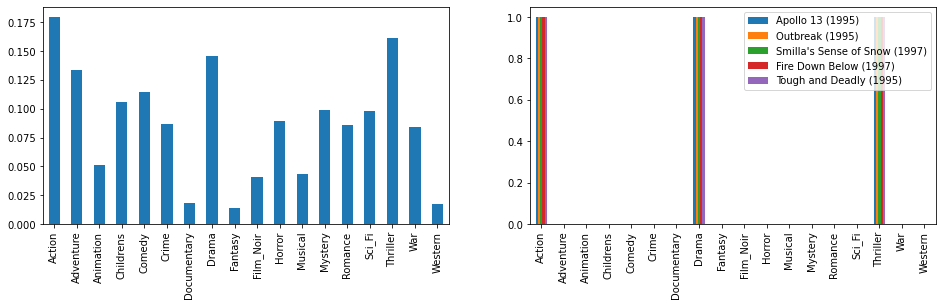

In [36]:
#user number 115
user_id = 115  
items, score = get_item_recommendations(users_profile,movies_profile,user_id)
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]);  
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1]);  
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title);

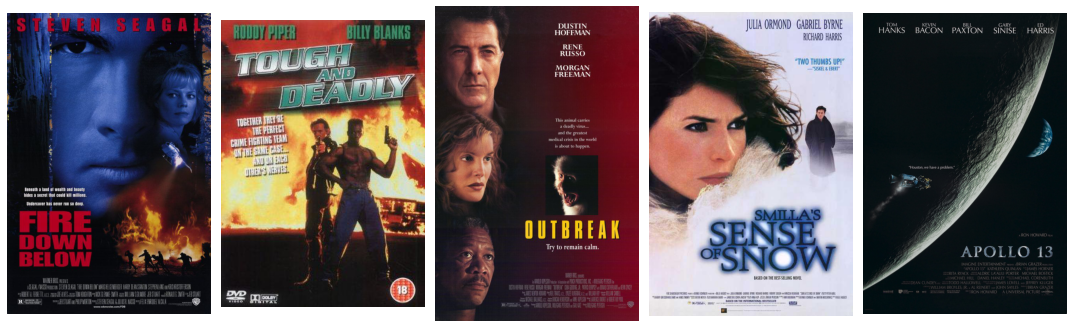

In [37]:
plot_pics(items+1,size = (15,10))

<u> **Insights:** </u> <br>
We see that user 115 has a strong Action,Drama,Thriller preferences hence he get recommended 5 movies which answer the exact triplet of attributs : Action-Drama-Thriller.

## User 131 examination

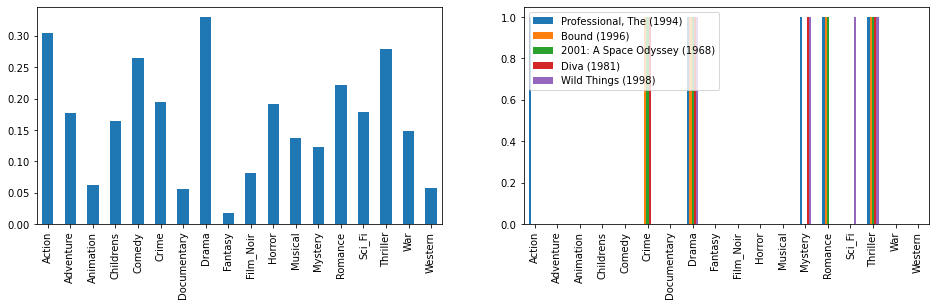

In [38]:
#user number 131
user_id = 131 
items, score = get_item_recommendations(users_profile,movies_profile,user_id)
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
users_profile.loc[user_id].plot(kind='bar',ax=axes[0]);  
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1]);  
plt.legend(df_items.loc[df_items.index.isin(items)].movie_title);

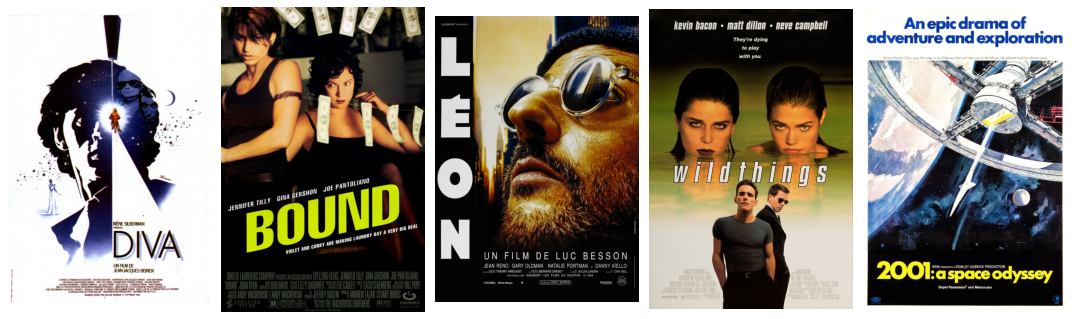

In [39]:
plot_pics(items+1,size = (15,10))

<u> **Insights:** </u> <br>
We see that user 131 has a strong Action,Drama,Thriller,Comedy,Romance preferences. Nevertheless the user got recommended absolute drama - Thrillers and 1 action movie. the rest affiliations were to crime and romance which were strong but not as strong as action preference. moreover the TFIDF missed completely Comedy genre! we're starting from this user to see some weaknesses that we might withness with CB recommendations

## Use the MRR metric to evaluate your recommender system on the test set. 
Use a cutoff value of 5.

In [40]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5'])

### Now we'll create the prediction matrix which stack each user's top  recommendation.
This dataframe will represent a "dummy" rating table, of "ratings" per user. in this way we can compare between the test and the actual predictions in MRR terms, without changing the code from assignment 1.

<u> **"Fit":** </u>

In [41]:
t = time.time()
irelevent_cols = ['unknown','release_date','video_release_date','IMDb_URL','movie_title','movie id']
movies_profile = df_items.drop(irelevent_cols,axis=1)
users_profile = get_users_profile(movies_profile,ratings,use_tfidf = True)
pred = pd.DataFrame().reindex_like(test).fillna(0)
for idx,_ in pred.iterrows():
    items,scores = get_item_recommendations(users_profile,movies_profile,idx,n=-1)
    pred.loc[idx,items + 1] = scores
fit_time = time.time() - t

In [42]:
final_results.loc[len(final_results)] = 'Content_Based', fit_time,0, my_metrics.MRR(test,pred.fillna(0),top_n=5,threshold=0.5)

In [43]:
final_results

Method     Time RMSE     MRR_5
0  Content_Based  8.90413    0  0.637724

**We notice how the MRR result is not that high - as expected of CB model which its accuracy is known to be limited**

<br><br><br><br><br>
# Question 4
# Content based recommendations vs. Matrix Factorization

### Use MF's  item representation to find the most similar items
Use the matrix factorization item representation you built in exercise 1 to find the most similar items for **the same 2 items** you used above. 
(Use your optimal hyperparams)

Compare the results you got using the different methods. Discuss your findings

In [44]:
# MF class
class MF():
    
    def __init__(self,df_train,n_factors=10,only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors #Latent vectors
        self.only_bias = only_bias #If True -> calculate only the bias variables, without the latent vectors
        self.recommended = ratings_full.copy()
        self.recommended[:] = 0
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        self.iterators = [(i, j, self.df_train[i, j]) for i in range(self.n_rows)
                          for j in range(self.n_cols)
                          if self.df_train[i, j] > 0 ] #Skip the zeros in the train!
        
        # biases
        self.original_bias_global = np.sum(df_train)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            self.u_i = np.zeros((self.n_rows,self.n_factors))
            self.v_j = np.zeros((self.n_cols,self.n_factors))
        else:
            self.u_i = np.random.standard_normal((self.n_rows,self.n_factors))
            self.v_j = np.random.standard_normal((self.n_cols,self.n_factors))
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = np.random.standard_normal(self.n_rows) # random bias derived from SN distribution
        self.bias_cols   = np.random.standard_normal(self.n_cols) # random bias derived from SN distribution
            
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True,
            D = 0):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
        self.D = D # decay factor for adaptive learning rate
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
        
        # please record the training time in fit_time
        self.fit_time = time.time()

        # please use the class functions 
        # for example(!) :
        for current_iteration in range(self.n_iterations):
            
            self.history.append(self.get_rmse(self.df_train))
#             print(self.history[-1]) #printer for debugging
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration!=0 and self.converging():
                
                if verbose:
                    print('converged...')
                break         
                
            self.optim_GD(current_iteration)
            
        self.recommended = pd.DataFrame(self.predict_full(),
                                        index = self.recommended.index,
                                        columns = self.recommended.columns) # get the prediction as dataframe
        
        self.fit_time = time.time() - self.fit_time
    
    def converging(self):
        return np.abs(self.history[-1] - self.history[-2]) < self.ϵ

                  
    def optim_GD(self,t):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        # We added option for adaptive learning rate
        for i,j,r in self.iterators:
            er = r - self.predict_one(i,j)
            self.bias_rows[i] = self.bias_rows[i] + (self.α/(1+self.D*t))*(er - self.λ*self.bias_rows[i])
            self.bias_cols[j] = self.bias_cols[j] + (self.α/(1+self.D*t))*(er - self.λ*self.bias_cols[j])
            if self.only_bias: continue
            u_i = self.u_i[i].copy() # it's being updated for self.u_i but the older value is still needed for self.v_j
            self.u_i[i] = self.u_i[i] + (self.α/(1+self.D*t))*(er*self.v_j[j] - self.λ*self.u_i[i])
            self.v_j[j] = self.v_j[j] + (self.α/(1+self.D*t))*(er*u_i  - self.λ*self.v_j[j])       
        
    def final_predict(self,N=10):
        pass
    
    def predict_full(self):
        return (np.dot(self.u_i,self.v_j.T) + self.bias_global + self.bias_rows[:,np.newaxis] + self.bias_cols[np.newaxis,:])
             
    def predict_one(self,i,j):
        return (np.dot(self.u_i[i],self.v_j[j].T) + self.bias_global + self.bias_rows[i,np.newaxis] + self.bias_cols[np.newaxis,j])
   
    def get_rmse(self,actulr):
        # please use my_metrics
        return my_metrics.RMSE(actulr,self.predict_full())

    
    def get_mrr(self,test,k=10,threshold=3):
        # Please use my_metrics
        actual = test[test > 0].dropna(how='all').fillna(0) # filter all none relevant test with no ratings whatsoever
        pred = self.recommended.reindex(index = actual.index , columns = actual.columns) # use the corresponding indices to the prediction also
        return my_metrics.MRR(actual,pred,top_n=k,threshold=threshold,MF = True)
    
    
    def get_ndcg(self,test,k=5):
        # please use my_metrics
        actual = test[test > 0].dropna(how='all').fillna(0) # filter all none relevant test with no ratings whatsoever
        pred = self.recommended.reindex(index = actual.index , columns = actual.columns) # use the corresponding indices to the prediction also
        return my_metrics.NDCG(actual,pred,top_n=k,MF = True)

In [45]:
model_mf = MF(train.values,n_factors=5)
model_mf.fit(n_iterations=20,learning_rate=0.01,regularization=0.1,convergence=0.001)

iteration:  0  total error:
 1.9292626096219514
iteration:  1  total error:
 1.177292907900087
iteration:  2  total error:
 1.0367360655608968
iteration:  3  total error:
 0.9804538990988505
iteration:  4  total error:
 0.9513515829651
iteration:  5  total error:
 0.9342250239088189
iteration:  6  total error:
 0.923216520727292
iteration:  7  total error:
 0.915636065313908
iteration:  8  total error:
 0.9101296202177857
iteration:  9  total error:
 0.9059466949809916
iteration:  10  total error:
 0.9026362562084804
iteration:  11  total error:
 0.8999278039078114
iteration:  12  total error:
 0.8976383321554169
iteration:  13  total error:
 0.8956448781545182
iteration:  14  total error:
 0.8938610038595128
iteration:  15  total error:
 0.8922220185174322
iteration:  16  total error:
 0.8906810978754558
iteration:  17  total error:
 0.8892000539058857
iteration:  18  total error:
 0.8877529173400927
iteration:  19  total error:
 0.8863171651522256


In [46]:
# record model results
final_results.loc[len(final_results)] = 'MF_20_iter', model_mf.fit_time, model_mf.get_rmse(test), model_mf.get_mrr(test,k=5)
final_results

Method       Time      RMSE     MRR_5
0  Content_Based   8.904130         0  0.637724
1     MF_20_iter  35.449333  0.964011  0.721591

In [47]:
# function using the MF class 
def get_MF_similar_items(MF,item_id, n=5):
    return get_corr_df(model_mf.v_j,item_id,n) # use the latent vectors of the items from the MF model!

In [48]:
#Batman and robin:
mf_sim1 = get_MF_similar_items(model_mf,253, n=5)
mf_sim1

movie_title  Similarity  Action  \
253                               Batman & Robin (1997)    1.000000       1   
311      Midnight in the Garden of Good and Evil (1997)    0.974777       0   
1486                 Even Cowgirls Get the Blues (1993)    0.973425       0   
924                                Unforgettable (1996)    0.966938       0   
1120  Umbrellas of Cherbourg, The (Parapluies de Che...    0.947288       0   
216                        Bram Stoker's Dracula (1992)    0.945930       0   

      Adventure  Animation  Childrens  Comedy  Crime  Documentary  Drama  \
253           1          0          0       0      1            0      0   
311           0          0          0       1      1            0      1   
1486          0          0          0       1      0            0      0   
924           0          0          0       0      0            0      0   
1120          0          0          0       0      0            0      1   
216           0          0          0       0      0            0      0   

      Fantasy  Film_Noir  Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  \
253         0          0       0        0        0        0       0         0   
311         0          0       0        0        1        0       0         0   
1486        0          0       0        0        0        1       0         0   
924         0          0       0        0        0        0       1         1   
1120        0          0       0        1        0        0       0         0   
216         0          0       1        0        0        1       0         0   

      War  Western  
253     0        0  
311     0        0  
1486    0        0  
924     0        0  
1120    0        0  
216     0        0

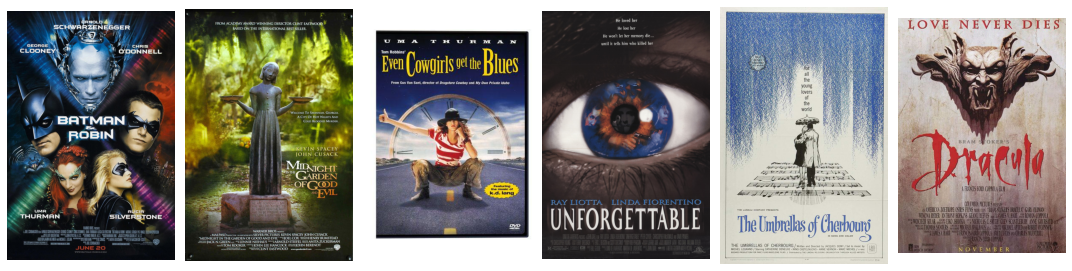

In [49]:
plot_pics(mf_sim1.index+1,size = (15,10))

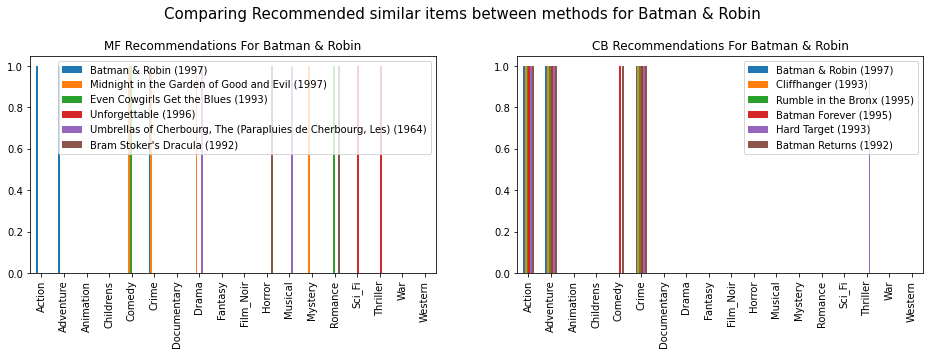

In [50]:
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
fig.suptitle('Comparing Recommended similar items between methods for Batman & Robin',fontsize = 15 ,y=1.05)
mf_sim1.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[0],title = 'MF Recommendations For Batman & Robin')
batdf.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For Batman & Robin')
axes[0].legend(mf_sim1.movie_title)
axes[1].legend(batdf.movie_title)
plt.show()

In [51]:
#The mask:
mf_sim2 = get_MF_similar_items(model_mf,71, n=5)
mf_sim2

movie_title  Similarity  Action  Adventure  \
71                       Mask, The (1994)    1.000000       0          0   
869                          Touch (1997)    0.973559       0          0   
928                Harriet the Spy (1996)    0.972004       0          0   
60             Three Colors: White (1994)    0.969955       0          0   
229  Star Trek IV: The Voyage Home (1986)    0.942740       1          1   
739                      Jane Eyre (1996)    0.933414       0          0   

     Animation  Childrens  Comedy  Crime  Documentary  Drama  Fantasy  \
71           0          0       1      1            0      0        1   
869          0          0       0      0            0      0        0   
928          0          1       1      0            0      0        0   
60           0          0       0      0            0      1        0   
229          0          0       0      0            0      0        0   
739          0          0       0      0            0      1        0   

     Film_Noir  Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  \
71           0       0        0        0        0       0         0    0   
869          0       0        0        0        1       0         0    0   
928          0       0        0        0        0       0         0    0   
60           0       0        0        0        0       0         0    0   
229          0       0        0        0        0       1         0    0   
739          0       0        0        0        1       0         0    0   

     Western  
71         0  
869        0  
928        0  
60         0  
229        0  
739        0

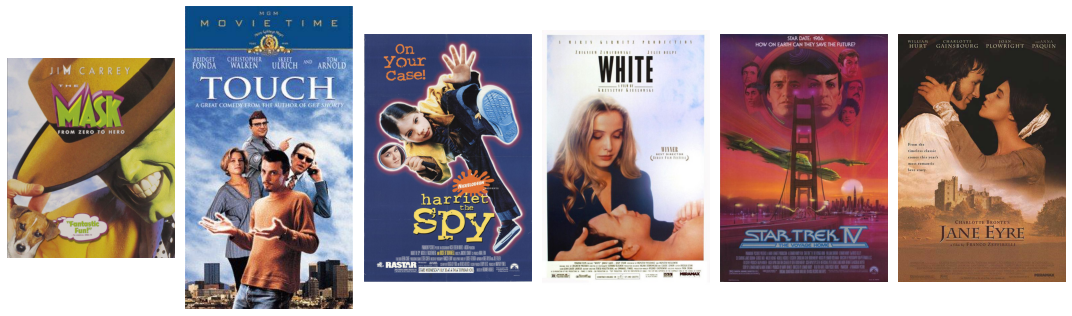

In [52]:
plot_pics(mf_sim2.index+1,size = (15,10))

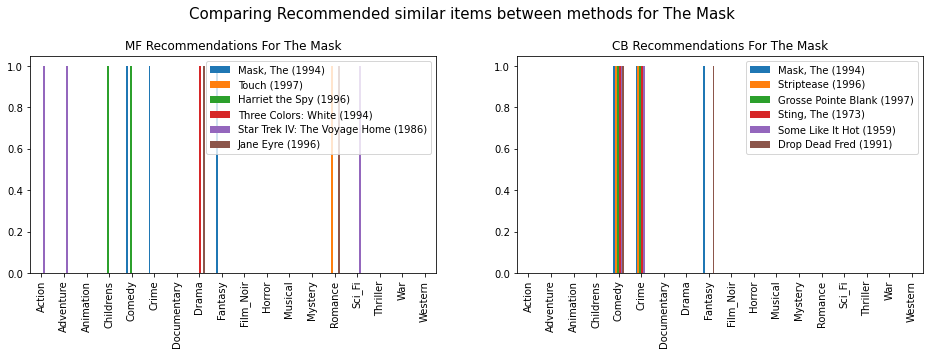

In [53]:
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
fig.suptitle('Comparing Recommended similar items between methods for The Mask',fontsize = 15 ,y=1.05)
mf_sim2.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[0],title = 'MF Recommendations For The Mask')
mask_df.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For The Mask')
axes[0].legend(mf_sim2.movie_title)
axes[1].legend(mask_df.movie_title)
plt.show()

### <u> **Insights For Both Batman_Robin and The mask:** </u> <br>
In both of the movies we see a unique behaviour for each recommendation method! <br>
While the CB method tries to recommend movies with the most "Similar" features in terms of the most similar genres of the chosen movie, the MF methods recommends a wider and more rich 'content' with extended genres - as shown in the genres histograms. <br><br>
This is a major defect in our opinion in CB recommendations because the user is exposed only to the exact most similar genres he prefers thus he doesnt get exposed to new "hybrid" genres and our system cant suggest a wider possibilities and open the user to new worlds of movies.<br><br>
The defect above of CB can harm the business model of a company which wants to try and suggest as many new items as she can in order to make the user purchase new items from different worlds.<br>
Hence, the histograms above shows the strength of the MF model, which can broaden the user's horizons and open him to new suggestions, not "more of the same" suggestions.

### Use MF implementation for item recommendations 

Use the matrix factorization implemention from exercise 1 to recommend 5 items to **the same 2 users** you used above. 
(Use your optimal hyperparams)

Compare the results you got using the different methods. Discuss your findings

In [54]:
def get_item_recommendations_using_MF(MF,user_id,n = 5):
    idx = MF.recommended.loc[user_id].nlargest(n).index
    return (df_items.set_index('movie id')).loc[idx][['movie_title']+movies_profile.columns.tolist()]

## User 115 examination

In [55]:
mf_user1 = get_item_recommendations_using_MF(model_mf,115,n = 5)
mf_user1

movie_title  Action  Adventure  Animation  \
item_id                                                                
1654      Chairman of the Board (1998)       0          0          0   
1587     Terror in a Texas Town (1958)       0          0          0   
1308                  Babyfever (1994)       0          0          0   
1596          Nemesis 2: Nebula (1995)       1          0          0   
1447                    Century (1993)       0          0          0   

         Childrens  Comedy  Crime  Documentary  Drama  Fantasy  Film_Noir  \
item_id                                                                     
1654             0       1      0            0      0        0          0   
1587             0       0      0            0      0        0          0   
1308             0       1      0            0      1        0          0   
1596             0       0      0            0      0        0          0   
1447             0       0      0            0      1        0          0   

         Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  Western  
item_id                                                                     
1654          0        0        0        0       0         0    0        0  
1587          0        0        0        0       0         0    0        1  
1308          0        0        0        0       0         0    0        0  
1596          0        0        0        0       1         1    0        0  
1447          0        0        0        0       0         0    0        0

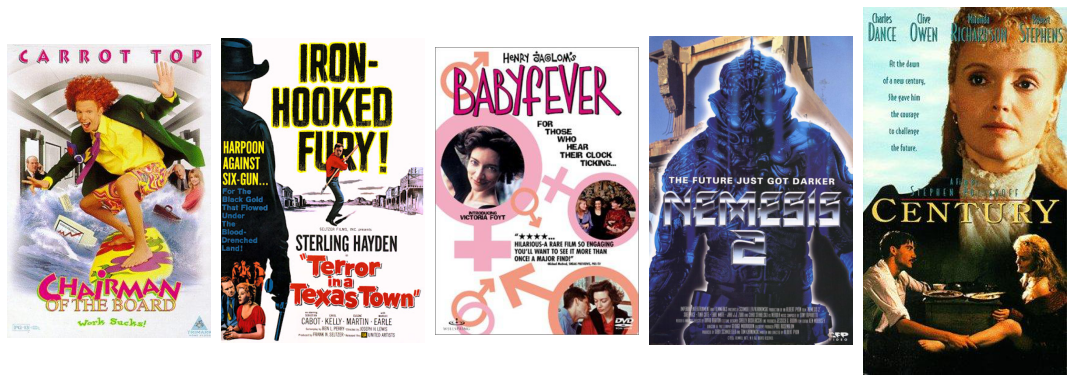

In [56]:
plot_pics(mf_user1.index,size = (15,10))

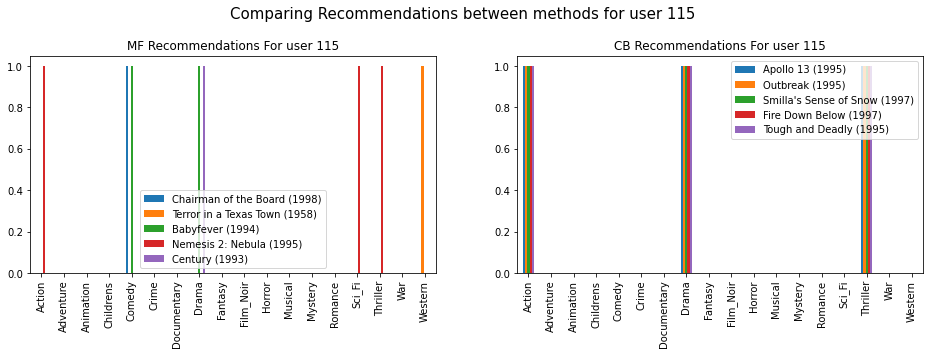

In [57]:
user_id = 115  
items, score = get_item_recommendations(users_profile,movies_profile,user_id)
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
fig.suptitle('Comparing Recommendations between methods for user 115',fontsize = 15 ,y=1.05)
mf_user1.drop(['movie_title'],axis = 1).T.plot(kind='bar',ax=axes[0],title = 'MF Recommendations For user 115')
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For user 115');
# mask_df.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For The Mask')
axes[0].legend(mf_user1.movie_title)
axes[1].legend(df_items.loc[df_items.index.isin(items)].movie_title)
plt.show()

<u> **Insights:** </u> <br>
We can see de-facto how MF offers a variety of different movies whereas CB offer a really similar movies in all aspects of genres.<br>
This is a weakness of CB in our opinion as already stated above.<br>
Nevertheless, the MF recommendations are quite questionable if they are good enough... we wish we could see in Real time the impact of deploying such system and see how good it behaves

## User 131 examination

In [58]:
mf_user2 =get_item_recommendations_using_MF(model_mf,131,n = 5)
mf_user2

movie_title  Action  Adventure  \
item_id                                                                         
1443                                      8 Seconds (1994)       0          0   
1510                                   Mad Dog Time (1996)       0          0   
868                                Hearts and Minds (1996)       0          0   
1323               Wooden Man's Bride, The (Wu Kui) (1994)       0          0   
1653     Entertaining Angels: The Dorothy Day Story (1996)       0          0   

         Animation  Childrens  Comedy  Crime  Documentary  Drama  Fantasy  \
item_id                                                                     
1443             0          0       0      0            0      1        0   
1510             0          0       0      1            0      0        0   
868              0          0       0      0            0      1        0   
1323             0          0       0      0            0      1        0   
1653             0          0       0      0            0      1        0   

         Film_Noir  Horror  Musical  Mystery  Romance  Sci_Fi  Thriller  War  \
item_id                                                                        
1443             0       0        0        0        0       0         0    0   
1510             0       0        0        0        0       0         0    0   
868              0       0        0        0        0       0         0    0   
1323             0       0        0        0        0       0         0    0   
1653             0       0        0        0        0       0         0    0   

         Western  
item_id           
1443           0  
1510           0  
868            0  
1323           0  
1653           0

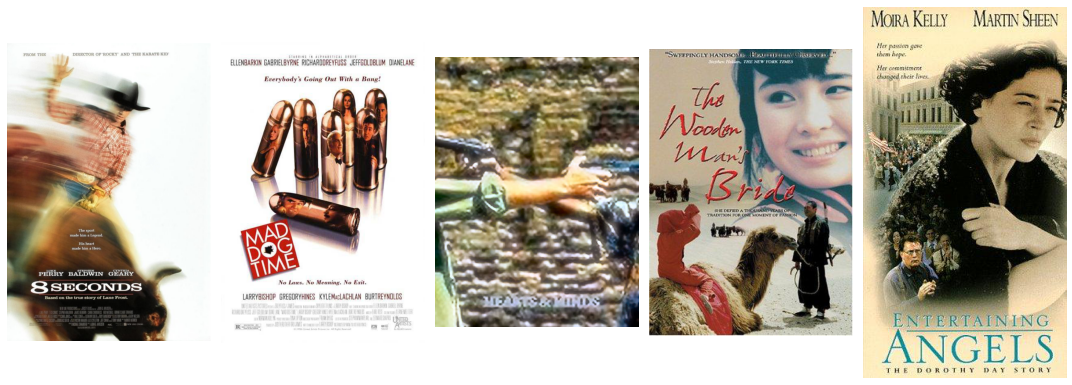

In [59]:
plot_pics(mf_user2.index,size = (15,10))

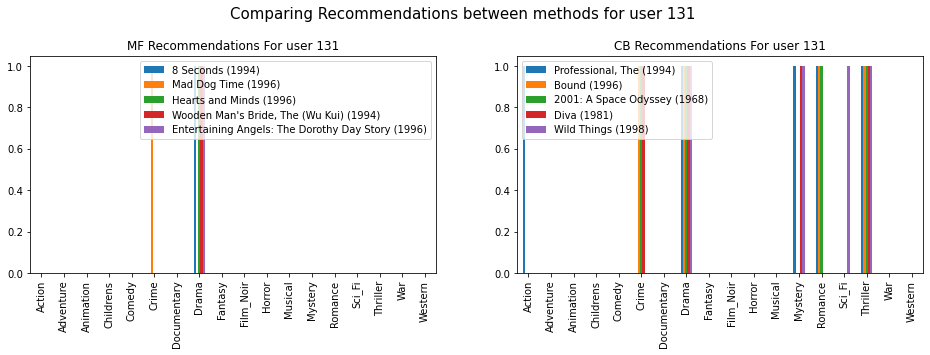

In [60]:
user_id = 131  
items, score = get_item_recommendations(users_profile,movies_profile,user_id)
fig, axes = plt.subplots(ncols=2,figsize=(16,4))  
fig.suptitle('Comparing Recommendations between methods for user 131',fontsize = 15 ,y=1.05)
mf_user2.drop(['movie_title'],axis = 1).T.plot(kind='bar',ax=axes[0],title = 'MF Recommendations For user 131')
movies_profile.iloc[items].T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For user 131');
# mask_df.drop(['Similarity','movie_title'],axis = 1).T.plot(kind='bar',ax=axes[1],title = 'CB Recommendations For The Mask')
axes[0].legend(mf_user2.movie_title)
axes[1].legend(df_items.loc[df_items.index.isin(items)].movie_title)
plt.show()

<u> **Insights:** </u> <br>
I really like this example because it shows quite the opposite trend we kept claiming about CB and MF.<br>
while MF recommends only 2-3 Genres(depends on the run - differs), CB recommends a variety of genres. <br>
that shows that both models have certain "flexibility" ( and not necessarily in a good way).<br>
this also shows that both models are not perfect and the "trends" are not decisive and absolute.<br>
That might imply that there is a need for a more "novel" and a hybrid approach between both models


### Compare the results of the content based recommender system to the matrix factorization recommender system

- Please use the same train and test set. 
- Please use the MRR metric for the comparison (use plot). 

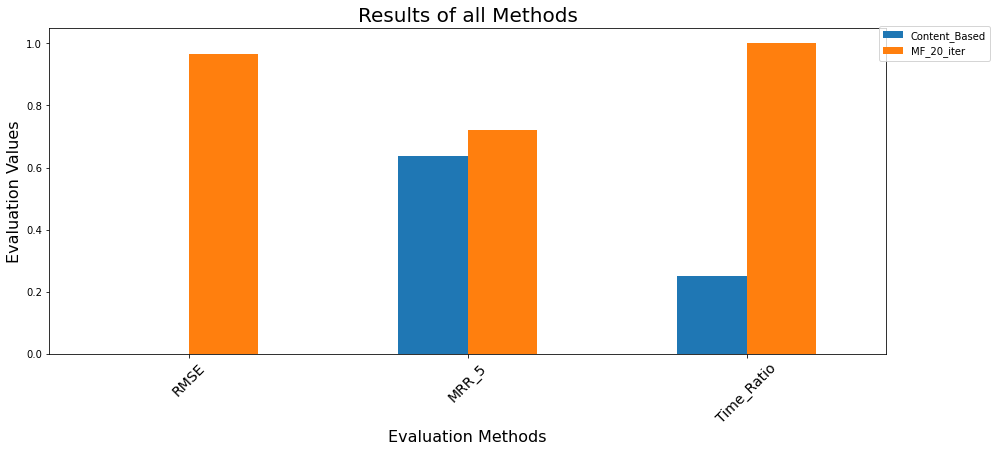

RMSE     MRR_5  Time_Ratio
Method                                       
Content_Based         0  0.637724    0.251179
MF_20_iter     0.964011  0.721591    1.000000

In [61]:
final_results_c = final_results.copy()
final_results_c = final_results_c.set_index('Method')
final_results_c['Time_Ratio'] = final_results_c['Time']/final_results_c['Time'].max()
final_results_c.drop(columns = ['Time'],inplace = True)
final_results_c.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.legend(loc='upper right',bbox_to_anchor=(1.13, 1.02))
plt.show();
final_results_c

<u> **Conclusions:** </u> <br>
1) We witness how the MRR of MF is better than CB which was expected. MF known to have better "accuracy" over CB and the MRR shows that the most relevant item is presented sooner with MF than CB.

2) The running time is in favor of CB, as expected, such that a CB is really good at building a quick baseline but MF results are more accurate in the long term.

3) There is a need for a more "novel" and a hybrid approach between both models which can "enjoy" both worlds of accuracy, and "warm" start for items.

### Advantages & Disadvantages 

Please use the following table to discuss the advantages and disadvantages of matrix factorization vs. content based recommender systems.
In your discussion please make sure to each of these rows and more...

<table>
    <thead>
        <tr>
            <th>..</th>
            <th style="text-align:center">Content-Based</th>
            <th style="text-align:center">Matrix-Factorization</th>
            <th style="text-align:left">Notes:</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>dimensionality</td>
            <td style="text-align:center">fixed features chosen by a prior desicion</td>
            <td style="text-align:center">Based on number of items and users. can be reduced</td>
            <td style="text-align:left">While the MF enables to describe seperatly the users and items with latent vectors<br> thus reduce dimensionality, CB features are decided and somewhat hardcoded<br> as hyperparameter or domain expertise</td>
        </tr>
        <tr>
            <td>Similarity</td>
            <td style="text-align:center">relies on the item content features</td>
            <td style="text-align:center">user to user method - relies on similar users and their behaviors (ratings)</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Accuracy</td>
            <td style="text-align:center">Limited</td>
            <td style="text-align:center">Can be relativly high</td>
            <td style="text-align:left">MF Based on users behavior. Considered more accurate than content-based</td>
        </tr>
        <tr>
            <td>Tranining Complexity</td>
            <td style="text-align:center">O(m) ~ Number of items</td>
            <td style="text-align:center">O(nm) ~ Number of items & users</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Inference Complexity</td>
            <td style="text-align:center">Great</td>
            <td style="text-align:center">Bad</td>
            <td style="text-align:left">Inference complexity - similar to explainability.<br> It will be much easier to explain the content based and<br> much more complex to explain the Matrix Factorization model.</td>
        </tr>
        <tr>
            <td>Explanability</td>
            <td style="text-align:center">Great</td>
            <td style="text-align:center">Bad</td>
            <td style="text-align:left">While its easy to understand the results and recommendations of CB,<br> the MF is hard to understand due to ambiguous meaning of latent features</td>
        </tr>
        <tr>
            <td>Scalability</td>
            <td style="text-align:center">Scalable!</td>
            <td style="text-align:center">Hardly Scalable at very big systems</td>
            <td style="text-align:left">MF requires alot of costly mathematical operations, and as the ratings/users<br>grows rapidly (and items maybe also)<br> the method becomes really computational power consuming when scales to very very large matrices</td>
        </tr>        
        <tr>
            <td>New User</td>
            <td style="text-align:center">Cold start problem</td>
            <td style="text-align:center">Cold start problem</td>
            <td style="text-align:left">In both, we need info on user in order to suggest relevant items.</td>
        </tr>
        <tr>
            <td>New Item</td>
            <td style="text-align:center">No cold start!</td>
            <td style="text-align:center">Cold start problem</td>
            <td style="text-align:left">in CB, the features of the new items extracted,<Br> thus enabling the system to understand its unique( or not) attributes<br> whereas in MF the system has no idea what to do for the new item until it gets rated</td>
        </tr>
        <tr>
            <td>Train Time</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Relatively slow</td>
            <td style="text-align:left">Due to learning process with optimization methods,<br> MF takes time to train on data</td>
        </tr>
        <tr>
            <td>Predict Time</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:center">Fast</td>
            <td style="text-align:left"></td>
        </tr>
        <tr>
            <td>Randomness</td>
            <td style="text-align:center">None</td>
            <td style="text-align:center">Exists</td>
            <td style="text-align:left">Due to hitting local minimas of the optimizers, slightly different learning outputs might occur in MF</td>
        </tr>
        <tr>
            <td>Trends</td>
            <td  style="text-align:center">Not Good</td>
            <td style="text-align:center">Not Good</td>
            <td style="text-align:left">CB and MF will not generalize good for trends. Nevertheless there are user trends modeling that are content based recommender system- can be seen here: https://www.semanticscholar.org/paper/User-trends-modeling-for-a-content-based-system-Bagher-Hassanpour/5ef0899efa891978cd2156674910fda8d97abd83</td>
        </tr>
        <tr>
            <td>Tradoff</td> 
            <td  style="text-align:center">Scales and explainable, quick to deploy as a basic model</td>
            <td style="text-align:center">Performance and robustness oriented for longer term system</td>
            <td style="text-align:left">While CB acts as a good baseline model,<br> and a well trained MF model performs better ,<br> both methods should be combined<br> to leverage advantages such as item cold start overcoming</td>
        </tr>
    </tbody>
</table>

<br>

Good Luck :)